In [18]:
# pip3 install opencv-python numpy matplotlib
import cv2 as cv

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from scipy.signal import find_peaks



In [19]:
# Create necessary dirs if they do not exist
direc= os.getcwd()
dirs = [direc+ "/linesdetected", direc+ "/output", direc+ "/cropped"]

for path in dirs:
    isExist = os.path.exists(path)

    if not isExist:
  
      # Create a new directory because it does not exist 
      os.makedirs(path)
      print("The new directory -{0} \n is created!".format(path))

In [20]:
# Source: https://medium.com/analytics-vidhya/binarization-of-image-using-numpy-65df2b82e189
def read_this(image_file, gray_scale=False):
    image_src = cv.imread(image_file)
    if gray_scale:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2GRAY)
    else:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2RGB)
    return image_src

In [21]:
import cv2
import numpy as np

#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
def contourFinder(img_path):
    contour = []
    image_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cropped = [];
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
    
        if (w*h < 40*40):
            continue
        if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
            continue
        contour.append(c)
        cropped.append(image_orig[y:y+h, x:x+w])
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
    i=0
    for k in cropped:
        cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
        i= i+1
    cv2.waitKey()
    return [i, contour]

In [22]:
def blackAndWhite(file):
    img = cv2.imread(file)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width, *rest= img.shape

    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                img[i, j] =255
            else:
                img[i, j] = 0
    return img

In [23]:
def calculateYProjection(array):
    img_row_sum = []
    for i in range(len(array)):
        img_row_sum.append(np.sum(array[i],axis=1).tolist())
    return img_row_sum

In [24]:
def calculatePeaks(array):
    peaks_of_image = []
    for i in range(len(array)):
        x =array[i]
        peaks, _ = find_peaks(x, distance=15)
        peaks_of_image.append(peaks)
    return peaks_of_image

In [25]:
def makeLines(array, peaks_image):
    images = array  
    for k,image in enumerate(array):
        newImage = image.copy()
        height, width= newImage.shape
        for i in range(height):
            if(i in peaks_image[k]):
                for j in range(width):
                    try:
                        newImage[i,j] = 255
                        newImage[i-1,j] = 255
                        newImage[i+1,j] = 255
                        newImage[i-2,j] = 255
                        newImage[i+2,j] = 255
                        newImage[i-3,j] = 255
                        newImage[i+3,j] = 255
                    except Exception as e:
                        continue
                        print("out of boundaries")
        plt.imshow(newImage, cmap='Greys_r')
        cv2.imwrite('linesdetected/cropped_image' + str(k) +'.png', newImage)

In [26]:
def assembleImage(original_image_size , contours, filename):

    img = Image.new('RGB', original_image_size[::-1] )
    plt.imshow(img, cmap='Greys_r')
    for idx, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        cr= Image.open('linesdetected/cropped_image' + str(idx) +'.png')
        plt.imshow(cr,cmap='Greys_r' )
        img.paste(cr, (x,y))
    img.save("output/" + filename[:-4] + "predicted.png")

In [27]:
def save_image(image, old_name, dir):
    if('_binarized' not in old_name):
        index = dir.find('.jpg')
        final_string = dir[:index] + '_binarized' + dir[index:]
        image.save(final_string)

In [28]:
def applyBinarizationAndSave():
    dir = os.getcwd()
    try:
        #assuming this file is one directory upper than images
        directory = os.fsencode(dir + '/images/')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                image_dir = dir + '/images/' + filename
                binarized_image = ApplyOtsu(image_file=image_dir)
                save_image(binarized_image, filename, image_dir)
            else:
                continue
                
    except Exception as e:
        print(e)

In [29]:
def ApplyOtsu(image_file, thresh_val=127, gray_scale=True):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    th, image_b = cv.threshold(image_src, 150, 255, cv.THRESH_BINARY)
    return Image.fromarray(image_b)

KeyboardInterrupt: 

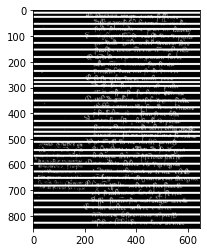

In [30]:
import os
import glob

def main():
    applyBinarizationAndSave()
    direc= os.getcwd()
    for img in glob.glob(direc + '/images' + '/*binarized*.jpg'):
        image_orig = cv2.imread(img)
        number_of_images, contours = contourFinder(img)

        array = []
        img_row_sum = []
        peaks_image = []


        for filename in glob.glob(direc + '/cropped' + '/*.png'):
            array.append(blackAndWhite(filename))
    
        img_row_sum = calculateYProjection(array)  

        peaks_image= calculatePeaks(img_row_sum)

        makeLines(array, peaks_image)

        k =image_orig.shape[:-1]
        assembleImage(k, contours, img.split("\\")[-1])

if __name__ == "__main__":
    main()  

In [ ]:
# algorith using histogram projection

In [34]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import sobel
import numpy as np
from PIL import Image
import glob
import os
import cv2
def horizontal_projections(img):
    return np.sum(img, axis=1)

def calculateXProjection(array):
    return np.sum(array,axis=0).tolist()

def find_peak_regions(hpp, divider=2.5):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

def main():
    direc= os.getcwd()



#Binarize all files in images
    #applyBinarizationAndSave()
    for img in glob.glob(direc + '/images' + '/*.jpg'):
        try:
            print(img)
            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            th, image = cv.threshold(image, 150, 255, cv.THRESH_BINARY)
            rightLeftEdge= int(600/5)
            rightRightEdge=int(770/5)
            sobel_image = sobel(image)
            hpp = calculateXProjection(sobel_image)
    #print(type(hpp))
    #print(hpp)
            temp = [sum(hpp[i:i+5]) for i in range(0, len(hpp), 5)]


            leftParagraphCornerIndex = int(temp.index(min(temp[40:60]))*5)
            RightParagraphCornerIndex = int(temp.index(min(temp[rightLeftEdge:rightRightEdge]))*5)

            sobel_image_left = sobel(image[:, :(leftParagraphCornerIndex)])
            sobel_image_middle = sobel(image[:, leftParagraphCornerIndex:RightParagraphCornerIndex])
            sobel_image_right = sobel(image[:, RightParagraphCornerIndex:])

            imag = [sobel_image_left, sobel_image_middle, sobel_image_right]

            new_image=[]
            for i in range(3):
                hpp = horizontal_projections(imag[i])
                peaks = find_peak_regions(hpp)
                if(len(peaks) == 0):
                    new_image.append(np.zeros(imag[i].shape, np.uint8))
                    continue
                    
                peaks_index = np.array(peaks)[:,0].astype(int)

                segmented_img = np.ones(imag[i].shape, np.uint8)

                r,c = segmented_img.shape
                for ri in range(r):
                    if ri in peaks_index:
                        segmented_img[ri, :] = 0
                
                new_image.append(segmented_img)
    
            sections_of_image=[]
            for k in new_image:
                height, width, *rest= k.shape
                for i in range(height):
                    for j in range(width):
                        if(j<30):
                            if (k[i, j] ==1):
                                k[i, j] =0
                sections_of_image.append(k)

            predictions = np.concatenate((sections_of_image[0], sections_of_image[1], sections_of_image[2]), axis=1)

            predictions[predictions == 1] = 255
            im = Image.fromarray(predictions)
            im.save("output/" + img[img.find("images")+7:])
        except Exception as e:
            break

if __name__ == "__main__":
    main()  

C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-018r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-018v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-019r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-019v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-020r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-021r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-021v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-022r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-022v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-023r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-023v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-024r_binari

C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-067v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-068r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-068v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-069r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-069v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-070r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-070v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-071r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-071v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-072r_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-072v_binarized.jpg
C:\Users\datog\Downloads\for-upload\DIA-Project/images\fmb-cb-55-073r_binari

In [ ]:
#Naive Hought Transform

In [ ]:
import cv2
import numpy as np
import cv2
import numpy as np
from math import atan2
import os
import glob
from PIL import Image
direc= os.getcwd()
i =0
for img in glob.glob(direc + '/images' + '/*.jpg'):
    image = cv2.imread(img)
#cv2.imshow('orig',image)
#cv2.waitKey(0)

#grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #cv2.imshow('binary',gray)
    cv2.waitKey(0)
    
    blurred_image = cv2.GaussianBlur(gray, (9, 9), 0)
    #cv2.imshow('blurred',blurred_image)
#binary
    ret,thresh = cv2.threshold(blurred_image,150,255,cv2.THRESH_BINARY_INV)
    #cv2.imshow('binary',thresh)
    cv2.waitKey(0)

#dilation
    kernel = np.ones((3,10), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    #cv2.imshow('dilated',img_dilation)

    kernel = np.ones((8,20), np.uint8)
    img_erosion = cv2.erode(img_dilation, kernel, iterations=1)
    #cv2.imshow('second',img_erosion)
    
    kernel = np.ones((1,30), np.uint8)  # note this is a horizontal kernel
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    #kernel = np.ones((8,20), np.uint8)
    #img_erosion = cv2.erode(img_dilation, kernel, iterations=1)
   # cv2.imshow('second',img_dilation)

#im = Image.fromarray(img_erosion)
#im.save("your_file.jpeg")

    BlackFrame = np.zeros(image.shape, np.uint8)

#gray = cv2.cvtColor(e_im, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_dilation, 75, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/90, 30, minLineLength = 40, maxLineGap=50)
    for line in lines:
        x1, y1, x2, y2 = line[0]
    
        if(x1!=x2 and (abs((y1-y2)/(x1-x2)) < np.pi/90)):
            cv2.line(BlackFrame, (x1, y1), (x2, y2), (255,255,255), 8)
    im = Image.fromarray(BlackFrame)
    im.save("output/" + img[img.find("images")+7:])
    i=i+1
#cv2.imshow("linesEdges", edges)
#cv2.imshow("linesDetected", BlackFrame)
cv2.waitKey(0)
cv2.destroyAllWindows()